In [1]:
import tensorflow as tf

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
fm=tf.keras.datasets.fashion_mnist.load_data()
(x_train,y_train),(x_test,y_test)=fm
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,stratify=y_train,random_state=42)

In [6]:
x_train=x_train/255.0
x_val=x_val/255.0
x_test=x_test/255.0

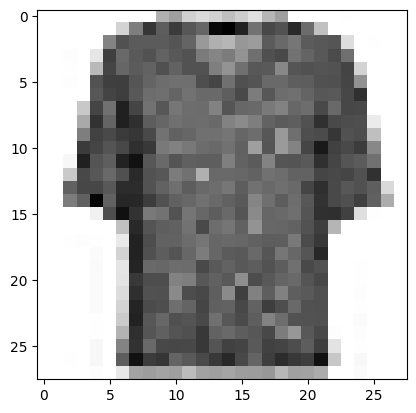

In [7]:
import matplotlib.pyplot as pl
pl.imshow(x_train[200],cmap='binary')
pl.show()

In [8]:
import numpy as np
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
x_train.shape

(54000, 28, 28)

In [26]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [39]:
class LatentLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        
        # Compute the latent loss
        latent_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
            axis=-1)
        
        # Add the loss to the model
        self.add_loss(tf.reduce_mean(latent_loss) / 784.)
        
        # Pass through the inputs as is
        return inputs

In [40]:
tf.random.set_seed(42) 

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  
codings_mean, codings_log_var = LatentLossLayer()([codings_mean, codings_log_var])
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [41]:
ve.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 28, 28)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 784)               │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 200)               │         157,000 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 100)               │          20,100 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 10)                │           1,010 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 10)                │           1,010 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling_1 (Sampling)         │ (None, 10)                │               0 │ dense_8[0][0],             │
│                               │                           │                 │ dense_9[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 179,120 (699.69 KB)

 Trainable params: 179,120 (699.69 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [43]:
vd.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 784)                 │         157,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,884 (698.77 KB)

 Trainable params: 178,884 (698.77 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [45]:
vae.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ [(None, 10), (None, 10),    │         179,120 │
│                                      │ (None, 10)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 28, 28)              │         178,884 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,004 (1.37 MB)

 Trainable params: 358,004 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(x_train, x_train, epochs=25, batch_size=128,
                             validation_data=(x_val, x_val))

Epoch 1/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0726 - val_loss: 0.0374
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0371 - val_loss: 0.0350
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0350 - val_loss: 0.0338
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0341 - val_loss: 0.0332
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0335 - val_loss: 0.0330
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0331 - val_loss: 0.0325
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0328 - val_loss: 0.0325
Epoch 8/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0326 - val_loss: 0.0321
Epoch 9/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0323 - val_loss: 0.0319
Epoch 10/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0321 - val_loss: 0.0318
Epoch 11/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0320 - val_loss: 0.0317
Epoch 12/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

In [57]:
tf.random.set_seed(42)  

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

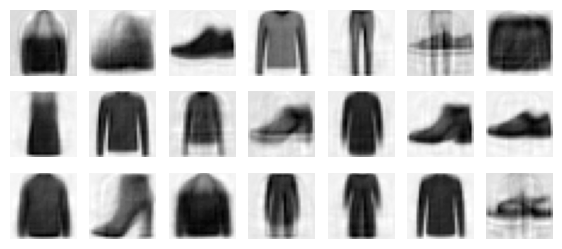

In [59]:

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)

In [60]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

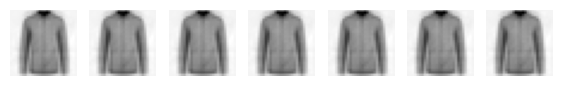

In [62]:
plot_multiple_images(images)
plt.show()